# Setup

## Packages

In [1]:
# data analysis
import scanpy as sc
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib import patches
from matplotlib.path import Path
import adjustText as adj
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

# utilities
import gc

## Functions

### shuffled embedding

In [2]:
def embedding_shuffled(
    adata,
    basis="X_umap",
    legend_fontsize=12,
    legend_fontoutline=3,
    add_outline=False,
    frameon=False,
    size=None,
    show=False,
    *args,
    **kwargs,
):
    np.random.seed(0)
    random_indices = np.random.permutation(list(range(adata.shape[0])))

    if size is None:
        size = 150000/adata.n_obs

    sc.pl.embedding(
        adata=adata[random_indices, :],
        basis=basis,
        legend_fontsize=legend_fontsize,
        legend_fontoutline=legend_fontoutline,
        add_outline=add_outline,
        frameon=frameon,
        size=size,
        show=show,
        *args,
        **kwargs,
    )

### Dotplot

In [3]:
def plot_dotplot(
    adata,
    genes,
    groupby='leiden',
    layer="log1p_norm",
    categories_order=None,
    dot_sizes = (2, 150),
    figsize=None,
    dpi=200,
    palette="RdYlBu_r",
    savepath=None,
    legend_size=(1.2, 0.1),
    legend_wspace=0.1,
    legend_height_ratios=None,
    margin_dotplot=(0.05, 0.05),
    swap_axes=False
):

    if isinstance(genes, str):
        gene_sets = None
        genes = [genes]
    elif isinstance(genes, dict):
        gene_sets = genes
        genes = [gene for gene_set in gene_sets.values() for gene in gene_set]
    else:
        gene_sets = None
    
    df_expression = sc.get.obs_df(
        adata,
        keys=[groupby] + genes,
        layer=layer,
    )

    df_means = df_expression.groupby(groupby).mean()
    df_means_norm = df_means.sub(df_means.min(axis=1), axis=0).div(
        df_means.max(axis=1) - df_means.min(axis=1), axis=0
    )
    df_bool = df_expression.set_index(groupby) > 0
    df_sizes = df_bool.groupby(level=0).sum() / df_bool.groupby(level=0).count()
    df_means_sizes = (
        df_means_norm.reset_index()
        .melt(id_vars=groupby, var_name="gene", value_name="expression")
        .merge(
            df_sizes.reset_index().melt(
                id_vars=groupby, var_name="gene", value_name="size"
            ),
            on=[groupby, "gene"],
        )
    )

    df_means_sizes[groupby] = df_means_sizes[groupby].cat.reorder_categories(
        categories_order
    )
    df_size_legend = pd.DataFrame(
        np.linspace(
            round(df_means_sizes["size"].max(), 1) / 5,
            round(df_means_sizes["size"].max(), 1),
            5,
        )
        * 100,
        columns=["sizes"],
    )

    df_size_legend["x"] = [0, 1, 2, 3, 4]
    df_size_legend["y"] = [0, 0, 0, 0, 0]

    if swap_axes and figsize is None:
        figsize = (70 / 25.4, 199.902 / 25.4)
    elif figsize is None:
        figsize = (199.902 / 25.4, 70 / 25.4)

    fig = plt.figure(figsize=figsize, dpi=dpi, layout="constrained")
    fig_w, fig_h = fig.get_size_inches()
    
    gs_main = gridspec.GridSpec(1,2, figure=fig, width_ratios=[fig_w - legend_size[0], legend_size[0]], wspace=legend_wspace)

    if legend_height_ratios is None:
        spacer = (fig_h - legend_size[1])/3

        gs_legends = gridspec.GridSpecFromSubplotSpec(
            5, 1, subplot_spec=gs_main[1], height_ratios=[spacer*3, legend_size[1]*2, spacer*1, legend_size[1], spacer/2]
        )

    ax_dotplot = fig.add_subplot(gs_main[0])

    # --- Dotplot ---
    if swap_axes:
        sns.scatterplot(
            df_means_sizes,
            x=groupby,
            y='gene',
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_yticklabels():
            label.set_style("italic")
        for label in ax_dotplot.get_xticklabels():
            label.set_rotation(90)
    else:
        sns.scatterplot(
            df_means_sizes,
            x="gene",
            y=groupby,
            hue="expression",
            size="size",
            sizes=dot_sizes,
            palette=palette,
            ax=ax_dotplot,
        )
        for label in ax_dotplot.get_xticklabels():
            label.set_style("italic")
            label.set_rotation(90)

    ax_dotplot.legend_.remove()
    ax_dotplot.set(ylabel="", xlabel="")

    if gene_sets is not None and swap_axes:
        new_coord = []
        y_ticklabels = []
        xmin, xmax = ax_dotplot.get_xlim()

        for text in ax_dotplot.get_yticklabels():
            y_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]
            
            gene_start_coord = y_ticklabels.index(gene_start)
            gene_end_coord = y_ticklabels.index(gene_end)
            
            new_coord.append((gene_start_coord-0.3, gene_end_coord+0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((xmax + 0.1, coord[0]))
            verts.append((xmax + 0.35, coord[0]))
            verts.append((xmax + 0.35, coord[1]))
            verts.append((xmax + 0.1, coord[1]))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                xmax + 1.3,
                coord_center,
                coord[2],
                ha="center",
                va="center",
                rotation=270,
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(path, facecolor="white", edgecolor="black", lw=1, clip_on=False)
        ax_dotplot.add_patch(patch)
    elif gene_sets is not None:
        new_coord = []
        x_ticklabels = []
        ymin, ymax = ax_dotplot.get_ylim()

        for text in ax_dotplot.get_xticklabels():
            x_ticklabels.append(text.get_text())

        for gene_set in gene_sets.keys():
            gene_start = gene_sets[gene_set][0]
            gene_end = gene_sets[gene_set][-1]
            
            gene_start_coord = x_ticklabels.index(gene_start)
            gene_end_coord = x_ticklabels.index(gene_end)
            
            new_coord.append((gene_start_coord-0.3, gene_end_coord+0.3, gene_set))

        verts = []
        codes = []

        for coord in new_coord:
            verts.append((coord[0], ymax - 0.1))
            verts.append((coord[0], ymax - 0.35))
            verts.append((coord[1], ymax - 0.35))
            verts.append((coord[1], ymax - 0.1))

            codes.append(Path.MOVETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)
            codes.append(Path.LINETO)

            coord_center = coord[0] + (coord[1] - coord[0]) / 2

            ax_dotplot.text(
                coord_center,
                ymax - 1,
                coord[2],
                ha="center",
                va="center",
                fontsize=8,
            )

        path = Path(verts, codes)

        patch = patches.PathPatch(path, facecolor="white", edgecolor="black", lw=1, clip_on=False)
        ax_dotplot.add_patch(patch)

    xmin, xmax = ax_dotplot.get_xlim()
    ymin, ymax = ax_dotplot.get_ylim()

    x_margin = (xmax - xmin) * margin_dotplot[0]
    y_margin = (ymax - ymin) * margin_dotplot[1]

    ax_dotplot.set_xlim(xmin - x_margin, xmax + x_margin)
    ax_dotplot.set_ylim(ymin - y_margin, ymax + y_margin)

    ax_size_legend = fig.add_subplot(gs_legends[1])

    sns.scatterplot(
        df_size_legend,
        x="x",
        y="y",
        size="sizes",
        sizes=dot_sizes,
        ax=ax_size_legend,
        legend=None,
        facecolors="grey",
        edgecolor="black",
    )
    ax_size_legend.set(ylabel="", xlabel="")
    ax_size_legend.set_xticks(df_size_legend["x"])
    ax_size_legend.set_xticklabels(df_size_legend["sizes"].astype(int))
    ax_size_legend.set_yticks([])
    ax_size_legend.spines[["right", "top", "left", "bottom"]].set_visible(False)
    ax_size_legend.margins(x=0.15, y=0.)
    ax_size_legend.set_title("Fraction of cells\nin group (%)", )

    ax_color_legend = fig.add_subplot(gs_legends[3])

    min_expression = round(df_means_sizes["expression"].min(), 1)
    max_expression = round(df_means_sizes["expression"].max(), 1)
    norm = Normalize(min_expression, max_expression)
    sm = ScalarMappable(norm=norm, cmap=palette)
    fig.colorbar(sm, cax=ax_color_legend, orientation="horizontal")
    ax_color_legend.set_xticks([min_expression, (min_expression + max_expression)/2, max_expression])
    ax_color_legend.set_title("Mean expression\nin group", )

    # --- Save or return ---
    if savepath:
        plt.savefig(savepath)
    return fig, ax_dotplot


## Dataset

Load dataset

In [ ]:
data_path = "/path/to/data/"

adata = sc.read_h5ad(f"{data_path}all_datasets.h5ad")

Extract wildling and spf data for the timepoints where we have both, namely p1, p7, p90 and p100. p90 and p100 will be summarized into one late timepoint. \
We do this by using the metadata of previously cleaned DETCs and LCs for wildling and germfree to reduce computational time. 

In [ ]:
lc_md = pd.read_excel(
    '/path/to/gene_sets/wildling_germfree_meatdata.xlsx',
    sheet_name='LC',
    index_col=0
)
detc_md = pd.read_excel(
    '/path/to/gene_sets/wildling_germfree_meatdata.xlsx',
    sheet_name='DETC',
    index_col=0
)

In [ ]:
metadata = pd.concat([lc_md, detc_md])

In [ ]:
adata = adata[metadata.index].copy()

adata.obs = metadata

## Colors

In [ ]:
colors = [
    "#66c5cc",
    "#f6cf71",
    "#f89c74",
    "#dcb0f2",
    "#87c55f",
    "#9eb9f3",
    "#fe88b1",
    "#c9db74",
    "#8be0a4",
    "#b497e7",
    "#d3b484",
    "#b3b3b3",
    "#89fade",
    "#817157",
    "#132b58",
]
leiden_colors = {f"{i}": colors[i] for i in range(15)}

In [ ]:
timepoint_colors = {
    "P1": "#bf812d",
    "P7": "#dfc27d",
    "P90-100": "#01665e",
}

In [ ]:
microbiota_status_colors = {
    'germfree': '#1b9e77',
    'spf': '#d95f02',
    'wildling': '#7570b3',
}

In [ ]:
cell_type_colors = {
    "DETC mature": "#1f78b4",
    "DETC cycling": "#a6cee3",
    "DETC cytotoxic": "#0099a8",
    "LC mature": "#e31a1c",
    "LC cycling": "#fb9a99",
    "LC immature": "#fdd49e",
    "LC maturing": "#fc4e2a",
}

## Preprocessing

In [ ]:
adata.X = adata.layers["raw_counts"].copy()

sc.pp.normalize_total(
    adata,
    target_sum=1e4,
)

sc.pp.log1p(adata)

adata.layers["log1p_norm"] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata, n_top_genes=2000, flavor="seurat_v3", layer="raw_counts"
)

sc.pp.scale(adata, max_value=10, zero_center=True)

adata.layers["scaled"] = adata.X.copy()

sc.pp.pca(
    adata,
)

sc.external.pp.harmony_integrate(adata, key="batch", adjusted_basis="harmony")

sc.pp.neighbors(
    adata,
    use_rep="harmony",
    n_neighbors=30,
)

sc.tl.umap(
    adata,
)

sc.tl.leiden(adata, resolution=0.8, flavor="igraph", n_iterations=2)

2025-09-03 16:35:58,678 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-09-03 16:36:05,532 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-09-03 16:36:05,860 - harmonypy - INFO - Iteration 1 of 10
2025-09-03 16:36:23,960 - harmonypy - INFO - Iteration 2 of 10
2025-09-03 16:36:42,999 - harmonypy - INFO - Iteration 3 of 10
2025-09-03 16:37:00,563 - harmonypy - INFO - Iteration 4 of 10
2025-09-03 16:37:17,914 - harmonypy - INFO - Iteration 5 of 10
2025-09-03 16:37:35,368 - harmonypy - INFO - Converged after 5 iterations


# Analysis

## Annotation

In [ ]:
cell_types = {
    "0": "LC mature",
    "1": "LC maturing",
    "2": "LC immature",
    "3": "LC cycling",
    "4": "DETC cycling",
    "5": "DETC mature",
    "6": "DETC mature",
    "7": "DETC mature",
    "8": "DETC mature",
    "9": "DETC cytotoxic",
    "10": "DETC cycling",
    "11": "DETC cycling",
}

adata.obs["cell_type"] = adata.obs["leiden"].map(cell_types)

# Figures

In [ ]:
plt.rcParams.update(
    {
        "font.family": "Arial",
        "font.size": 8,
        "axes.titlesize": "medium",
        "figure.titlesize": "medium",
        "figure.labelsize": "medium",
        "legend.fontsize": 8.0,
    }
)

## UMAPs

In [ ]:
umap_dot_size = 250000 / adata.n_obs
print(umap_dot_size)

3.102468323798414


In [ ]:
# Overall UMAP plot sizes, width gets changed if legend is added
plot_width_in = 60 / 25.4
plot_height_in = 45 / 25.4

# Margin around plot area in inches
margin_left = 0
margin_bottom = 0
margin_top = 6 / 25.4

# Legend spacer in inches
legend_width_in = 0
# legend_width_in = 1.27/25.4

### Cluster

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


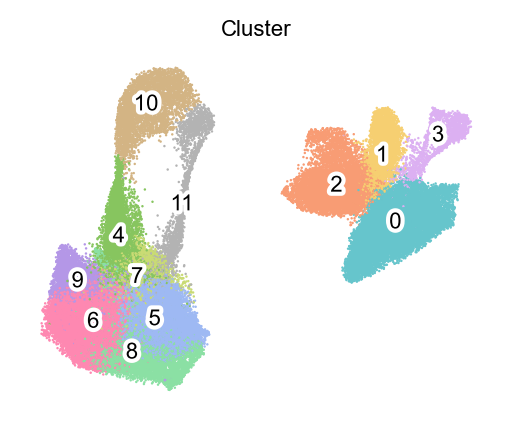

In [ ]:
margin_right = 0

fig_width = margin_left + plot_width_in + margin_right
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata,
    basis="X_umap",
    color="leiden",
    palette=leiden_colors,
    ax=axes,
    title="Cluster",
    legend_loc="on data",
    legend_fontsize="medium",
    legend_fontweight="normal",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

gc.collect()

### Timepoint

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


580

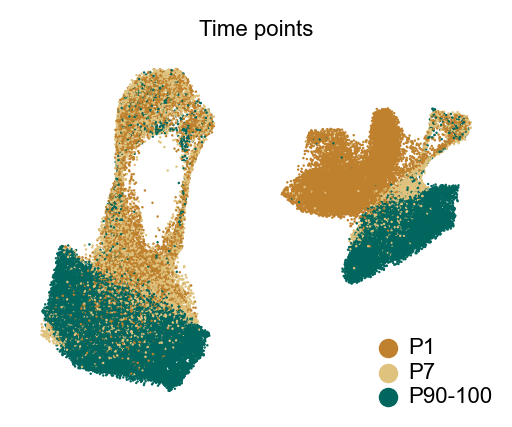

In [ ]:
margin_right = 0

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata,
    basis="X_umap",
    color="timepoint",
    palette=timepoint_colors,
    ax=axes,
    title="Time points",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="lower right",
    labelspacing=0.2,
    handletextpad=-0.1,
    frameon=False,
)

gc.collect()

### Microbiota status

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


3041

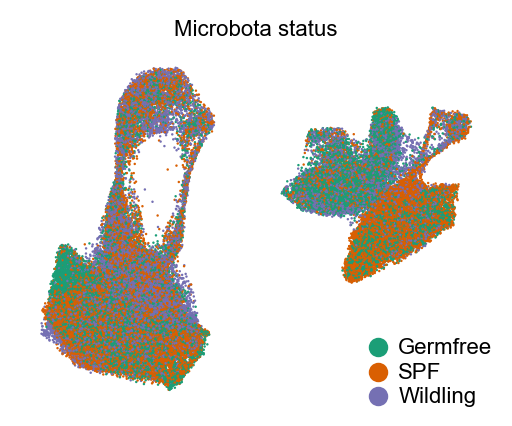

In [ ]:
margin_right = 0

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata,
    basis="X_umap",
    color="microbiota_status",
    palette=microbiota_status_colors,
    ax=axes,
    title="Microbota status",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
labels = ['Germfree', 'SPF', 'Wildling']
fig.legend(
    handles,
    labels,
    loc="lower right",
    labelspacing=0.2,
    handletextpad=-0.1,
    frameon=False,
)

gc.collect()

### Cell type

In [ ]:
adata.obs["cell_type"] = adata.obs["cell_type"].cat.reorder_categories(
    [
        "DETC cycling",
        "DETC mature",
        "DETC cytotoxic",
        "LC immature",
        "LC cycling",
        "LC maturing",
        "LC mature",
    ]
)

/home/david/anaconda3/envs/skin_development/lib/python3.12/site-packages/scanpy/plotting/_utils.py:488: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


3175

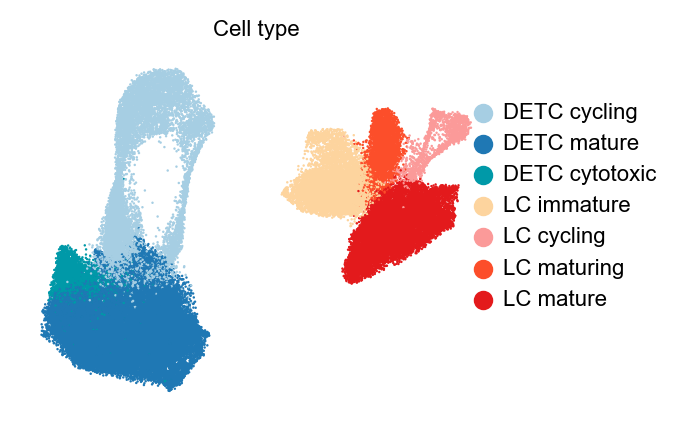

In [ ]:
margin_right = (
    21.5 / 25.4
)

fig_width = (
    margin_left + plot_width_in + legend_width_in + margin_right
)
fig_height = margin_bottom + plot_height_in + margin_top

fig, axes = plt.subplots(figsize=(fig_width, fig_height), dpi=200, layout="constrained")
embedding_shuffled(
    adata,
    basis="X_umap",
    color="cell_type",
    palette=cell_type_colors,
    ax=axes,
    title="Cell type",
    size=umap_dot_size,
)

axes.set_position(
    [
        margin_left / fig_width,
        margin_bottom / fig_height,
        plot_width_in / fig_width,
        plot_height_in / fig_height,
    ]
)

handles, labels = axes.get_legend_handles_labels()
axes.legend_.remove()
fig.legend(
    handles,
    labels,
    loc="center left",
    bbox_to_anchor=(0.92 - (margin_right / fig_width), 0.5),
    handletextpad=-0.1,
    frameon=False,
)

gc.collect()

## Barplot

In [ ]:
df = sc.get.obs_df(adata, keys=["microbiota_status", "timepoint", "cell_type"])

In [ ]:
df = (
    df.reset_index()
    .assign(
        microbiota_timepoint=lambda df: df["microbiota_status"].astype(str)
        + "_"
        + df["timepoint"].astype(str)
    )
    .drop(columns=["microbiota_status", "timepoint"])
    .groupby(["microbiota_timepoint", "cell_type"], observed=True)
    .count()
    .reset_index()
    .rename(columns={"index": "count"})
    .assign(
        count_norm=lambda df: df["count"]
        / df.groupby("microbiota_timepoint")["count"].transform("sum")
    )
)

df["microbiota_timepoint"] = (
    df["microbiota_timepoint"]
    .astype("category")
    .cat.reorder_categories(
        [
            "germfree_P1",
            "spf_P1",
            "wildling_P1",
            "germfree_P7",
            "spf_P7",
            "wildling_P7",
            "germfree_P90-100",
            "spf_P90-100",
            "wildling_P90-100",
        ]
    )
)

df_wide = df.pivot(
    index="microbiota_timepoint", columns="cell_type", values="count_norm"
).fillna(0)

In [ ]:
x_ticklabel_dict = {
    'P1': ['germfree_P1', 'spf_P1', 'wildling_P1'],
    'P7': ['germfree_P7', 'spf_P7', 'wildling_P7'],
    'P90-100': ['germfree_P90-100', 'spf_P90-100', 'wildling_P90-100'],
}

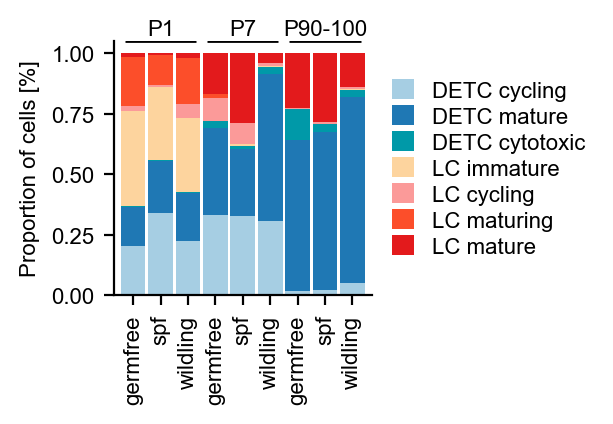

In [ ]:
fig, axes = plt.subplots(
    1, 1, figsize=(75 / 25.4, 51 / 25.4), dpi=200, layout="constrained"
)

p1 = df_wide.plot(kind="bar", stacked=True, width=0.9, color=cell_type_colors, ax=axes)

p1.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False, labelspacing=0.2, handlelength=1, handleheight=1)

p1.set_xlabel("")
p1.set_ylabel(
    "Proportion of cells [%]",
)

p1.spines["right"].set_visible(False)
p1.spines["top"].set_visible(False)

x_ticklabels = []
coords = []

ymin, ymax = p1.get_ylim()

for text in p1.get_xticklabels():
    x_ticklabels.append(text.get_text())

for tp in x_ticklabel_dict.keys():
    start = x_ticklabels.index(x_ticklabel_dict[tp][0])
    end = x_ticklabels.index(x_ticklabel_dict[tp][-1])

    coords.append((start-0.3, end+0.3, tp))

verts = []
codes = []

for coord in coords:
    verts.append((coord[0], ymax ))
    verts.append((coord[1], ymax ))

    codes.append(Path.MOVETO)
    codes.append(Path.LINETO)

    p1.text(
        (coord[0] + coord[1]) / 2,
        ymax + 0.05,
        coord[2],
        ha="center",
        va="center",
        rotation=0,
    )

path = Path(verts, codes)

patch = patches.PathPatch(path, facecolor="white", linewidth=1)
p1.add_patch(patch)

x_ticklabels_new = [x_tlabel.split("_")[0] for x_tlabel in x_ticklabels]

p1.set_xticklabels(x_ticklabels_new, rotation=90)

## Harmony embeddings

In [ ]:
df_obs = sc.get.obs_df(adata, keys=["microbiota_status", 'timepoint', "cell_type"])

df_harmony = pd.DataFrame(
    adata.obsm["harmony"][:, 0:2], columns=["harmony_1", "harmony_2"], index=adata.obs_names
)

df_embedding = df_obs.merge(df_harmony, left_index=True, right_index=True)

### DETCs

In [ ]:
df_embedding_detc = (
    df_embedding[df_embedding['cell_type'].str.startswith('DETC')]
    .drop('cell_type', axis=1)
    .reset_index(drop=True)
    .groupby(['microbiota_status', 'timepoint'], observed=True)
    .median()
    .reset_index()
    .assign(
        timepoint_microbiota = lambda df: df['timepoint'].astype(str) + ' ' + df['microbiota_status'].astype(str)
    )
)

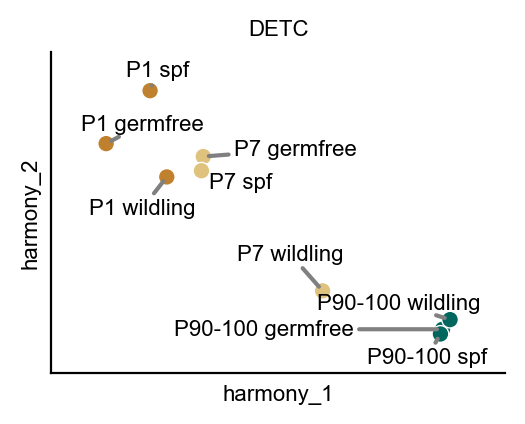

In [ ]:
fig, axes = plt.subplots(figsize=(63.72035/25.4, 51/25.4), dpi=200, layout = "constrained")

sns.scatterplot(
    data=df_embedding_detc,
    x='harmony_1',
    y='harmony_2',
    hue='timepoint',
    palette=timepoint_colors,
    legend = None
)

xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

axes.set_xlim(xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
axes.set_ylim(ymin - 0.1 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))

texts = []

for i, tp, mb_status in df_embedding_detc[['timepoint', 'microbiota_status']].itertuples():
    texts.append(plt.text(df_embedding_detc.loc[i, 'harmony_1'], df_embedding_detc.loc[i, 'harmony_2'], tp + ' ' + mb_status, ha='center'))

adj.adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="grey", lw=1.5),
    expand=(1, 1.2),
    force_text=(0.5, 1),
)

axes.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
axes.set_title('DETC')

axes.spines[['top', 'right']].set_visible(False)

### LCs

In [ ]:
df_embedding_lc = (
    df_embedding[df_embedding['cell_type'].str.startswith('LC')]
    .drop('cell_type', axis=1)
    .reset_index(drop=True)
    .groupby(['microbiota_status', 'timepoint'], observed=True)
    .median()
    .reset_index()
    .assign(
        timepoint_microbiota = lambda df: df['timepoint'].astype(str) + ' ' + df['microbiota_status'].astype(str)
    )
)

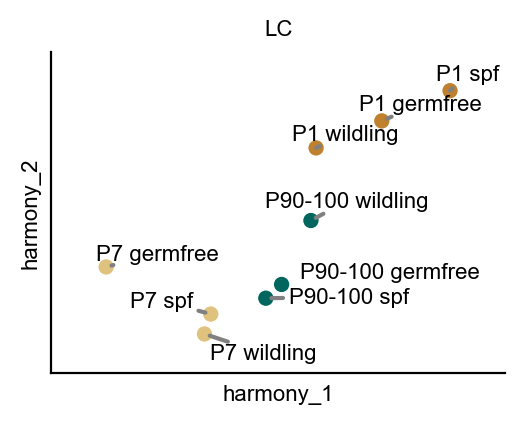

In [ ]:
fig, axes = plt.subplots(figsize=(63.72035/25.4, 51/25.4), dpi=200, layout = "constrained")

sns.scatterplot(
    data=df_embedding_lc,
    x='harmony_1',
    y='harmony_2',
    hue='timepoint',
    palette=timepoint_colors,
    legend = None
)

xmin, xmax = axes.get_xlim()
ymin, ymax = axes.get_ylim()

axes.set_xlim(xmin - 0.1 * (xmax - xmin), xmax + 0.1 * (xmax - xmin))
axes.set_ylim(ymin - 0.1 * (ymax - ymin), ymax + 0.1 * (ymax - ymin))

texts = []

for i, tp, mb_status in df_embedding_lc[['timepoint', 'microbiota_status']].itertuples():
    texts.append(plt.text(df_embedding_lc.loc[i, 'harmony_1'], df_embedding_lc.loc[i, 'harmony_2'], tp + ' ' + mb_status, ha='center'))

adj.adjust_text(
    texts,
    arrowprops=dict(arrowstyle="-", color="grey", lw=1.5),
    expand=(1, 1.2),
    force_text=(0.5, 1),
)

axes.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
axes.set_title('LC')

axes.spines[['top', 'right']].set_visible(False)

# Supplementary figure

## Dotplot

<positron-console-cell-72>:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
<positron-console-cell-72>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


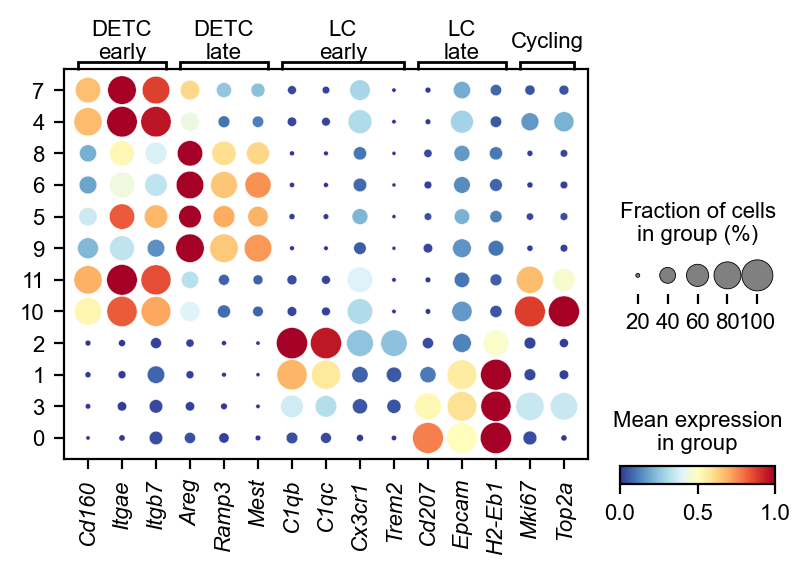

In [ ]:
genes = {
    "DETC\nearly": [
        "Cd160",
        "Itgae",
        "Itgb7",
    ],
    "DETC\nlate": [
        "Areg",
        "Ramp3",
        "Mest",
    ],
    "LC\nearly": [
        "C1qb",
        "C1qc",
        "Cx3cr1",
        "Trem2",
    ],
    "LC\nlate": [
        "Cd207",
        "Epcam",
        "H2-Eb1",
    ],
    "Cycling": [
        'Mki67',
        'Top2a'
    ]
}

order_cluster = ['7', '4', '8', '6', '5', '9', '11', '10', '2', '1', '3', '0']

fig, ax_dotplot = plot_dotplot(
    adata,
    genes=genes,
    groupby="leiden",
    categories_order=order_cluster,
    swap_axes=False,
    figsize=(100 / 25.4, 70 / 25.4),
    legend_size=(1.1, 0.25),
    legend_wspace=0.0,
    legend_height_ratios=None,
    dot_sizes=(2, 125),
    margin_dotplot=(0.0, 0.01),
)

# Saving

For cell-cell communication.

In [ ]:
adata.write_h5ad(f'{data_path}wildling_germfree_cleaned.h5ad')